In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Ensure the input size is suitable for LeNet
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the RGB images
])

# Load CIFAR-10 dataset
cifar10_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_testset = datasets.CIFAR10(root='./data', train=False, transform=transform)


/Users/chrispark/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/chrispark/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/chrispark/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/chrispark/anaconda3/lib/python3.11/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Files already downloaded and verified


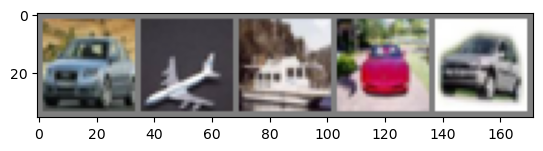

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(DataLoader(cifar10_trainset, batch_size=5, shuffle=True))
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))


In [4]:
# Splitting the dataset
train_size = int(0.9 * len(cifar10_trainset))
val_size = len(cifar10_trainset) - train_size
cifar10_train, cifar10_val = random_split(cifar10_trainset, [train_size, val_size])

# Creating data loaders
train_loader = DataLoader(cifar10_train, batch_size=32, shuffle=True)
val_loader = DataLoader(cifar10_val, batch_size=32, shuffle=False)


In [5]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # Adapt for 3-channel inputs
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet()


Epoch 1 training loss: 1.616714227640129
Epoch 1 validation loss: 1.4338423492042882
Epoch 2 training loss: 1.3409253482964332
Epoch 2 validation loss: 1.2742679236800807
Epoch 3 training loss: 1.2190607024493079
Epoch 3 validation loss: 1.2180703783490856
Epoch 4 training loss: 1.1363086251816008
Epoch 4 validation loss: 1.1846719308263938
Epoch 5 training loss: 1.0706831479462309
Epoch 5 validation loss: 1.1319119432929214
Epoch 6 training loss: 1.0224429873727108
Epoch 6 validation loss: 1.1011576124816944
Epoch 7 training loss: 0.9752079676293954
Epoch 7 validation loss: 1.142834004323194
Epoch 8 training loss: 0.9304024757183268
Epoch 8 validation loss: 1.0866047924111604
Epoch 9 training loss: 0.8899766206317704
Epoch 9 validation loss: 1.0809124489878392
Epoch 10 training loss: 0.856269321843251
Epoch 10 validation loss: 1.083737789445622
Epoch 11 training loss: 0.8217307824612342
Epoch 11 validation loss: 1.1026498479827953
Epoch 12 training loss: 0.7895431286405822
Epoch 12 va

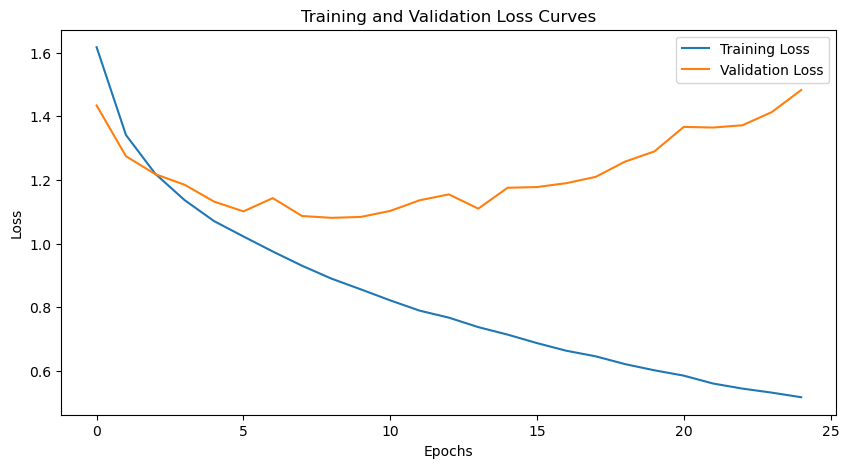

In [6]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Set up optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Initialize lists to track the losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(25):  # Adjust the number of epochs as needed
    running_loss = 0.0
    model.train()  # Set model to training mode
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Record training loss
    train_losses.append(running_loss / len(train_loader))
    print(f'Epoch {epoch + 1} training loss: {running_loss / len(train_loader)}')

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Record validation loss
    val_losses.append(val_loss / len(val_loader))
    print(f'Epoch {epoch + 1} validation loss: {val_loss / len(val_loader)}')

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [7]:
# Evaluate accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the validation images: {100 * correct / total}%')

# Predict on the test set
test_loader = DataLoader(cifar10_testset, batch_size=32, shuffle=False)
predictions = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.tolist())

print(predictions[:10])  # Print the first 10 predictions


Accuracy of the network on the validation images: 60.98%
[5, 8, 8, 8, 4, 6, 5, 6, 3, 1]
